<a href="https://colab.research.google.com/github/14-shru/NNDL_LAB-2022/blob/main/RNN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/monthly_milk_production.csv',index_col='Date',parse_dates=True)   #Date is not  string
df.index.freq='MS'

In [3]:
df.head()

,Monthly milk production (pounds per cow)
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


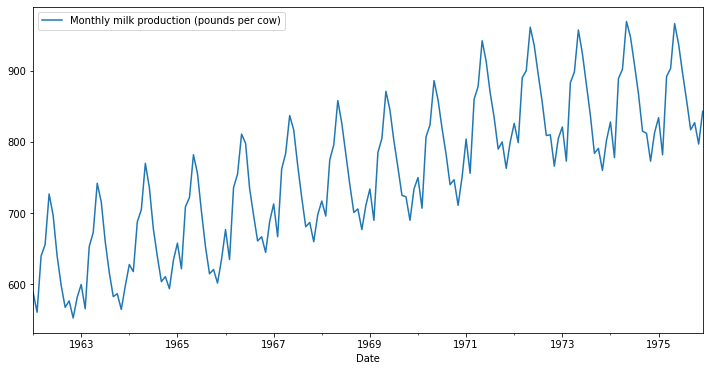

In [4]:
df.plot(figsize=(12,6))

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


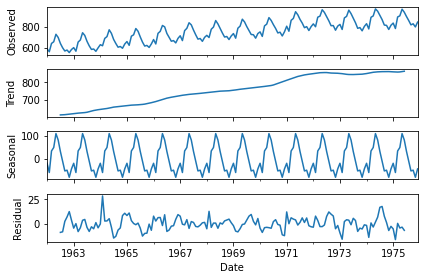

In [7]:
results = seasonal_decompose(df['Monthly milk production (pounds per cow)'])
results.plot();

In [8]:
len(df)

168

In [9]:
train = df.iloc[:156]        # all data except the last 12 months data 168-12=156
test = df.iloc[156:]         # Last 12 months data

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [11]:
df.head(),df.tail()       #magnitude of the production values not in proper range

(            Monthly milk production (pounds per cow)
 Date                                                
 1962-01-01                                       589
 1962-02-01                                       561
 1962-03-01                                       640
 1962-04-01                                       656
 1962-05-01                                       727,
             Monthly milk production (pounds per cow)
 Date                                                
 1975-08-01                                       858
 1975-09-01                                       817
 1975-10-01                                       827
 1975-11-01                                       797
 1975-12-01                                       843)

In [12]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [13]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [14]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [16]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [17]:
X.shape        # 1 row 3 columns and 1 feature

(1, 3, 1)

In [18]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [20]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [22]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 5s 13ms/step - loss: 0.0553
Epoch 2/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0261
Epoch 3/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0201
Epoch 4/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0137
Epoch 5/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0094
Epoch 6/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0081
Epoch 7/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0042
Epoch 8/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0039
Epoch 9/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0032
Epoch 10/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0033
Epoch 11/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0040
Epoch 12/50
144/144 [==============================] - 1s 6ms/step - loss: 0.0039
Epoch 13/50
144/144 [===

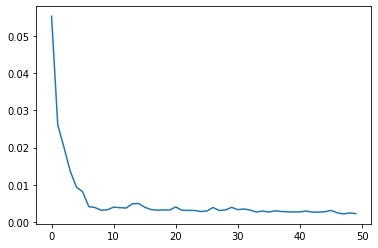

In [23]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [24]:
last_train_batch = scaled_train[-12:]

In [25]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [26]:
model.predict(last_train_batch)

array([[0.60337764]], dtype=float32)

In [27]:
scaled_test[0]      # original value was 0.67 model predicted it to be 0.65

array([0.67548077])

In [28]:
test_predictions = []     #empty list of test predictions

first_eval_batch = scaled_train[-n_input:]      #last 12 values from the training set
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [29]:
test_predictions

[array([0.60337764], dtype=float32),
 array([0.6086004], dtype=float32),
 array([0.75049907], dtype=float32),
 array([0.8380588], dtype=float32),
 array([0.92090076], dtype=float32),
 array([0.9086556], dtype=float32),
 array([0.8458185], dtype=float32),
 array([0.7400765], dtype=float32),
 array([0.6398032], dtype=float32),
 array([0.59442306], dtype=float32),
 array([0.560856], dtype=float32),
 array([0.5842672], dtype=float32)]

In [30]:
test.head()

,Monthly milk production (pounds per cow)
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [31]:
true_predictions = scaler.inverse_transform(test_predictions)

In [32]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


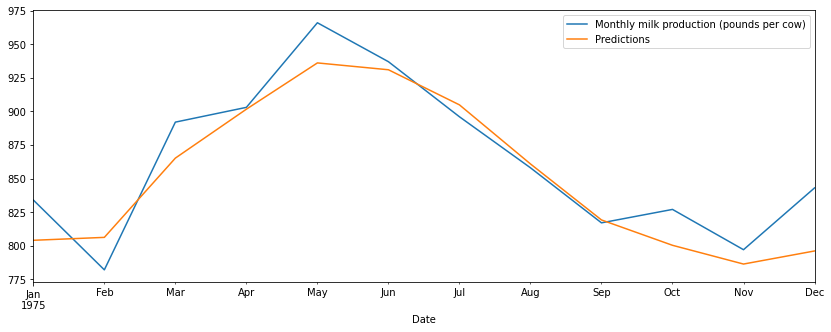

In [33]:
test.plot(figsize=(14,5))

In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Monthly milk production (pounds per cow)'],test['Predictions']))
print(rmse)

22.835670427963013
